# Mapping changing water extents through time

* **Products used:** 
[wofs_ls](https://explorer.digitalearth.africa/products/wofs_ls)
[Chirps](https://explorer.digitalearth.africa/products/rainfall_chirps_monthly)



## Background
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 6.6.1 - change in the extent of water-related ecosystems. Indicator 6.6.1 has 4 sub-indicators:

>    i. The spatial extent of water-related ecosystems <br>
>    ii. The quantity of water contained within these ecosystems <br>
>    iii. The quality of water within these ecosystems <br>
>    iv. The health or state of these ecosystems <br>

This notebook primarily focuses on the first sub-indicator - spatial extents.

Water extent is estimated using Sentinel-2 satellite images and the Modified Normalised Difference Water Index (MNDWI).


## Description
The notebook loads Setinel-2 data for a given shapefile (the Ruko Conservancy in the default example) and calculates the changing water extent of Lake Baringo and surrounds.  

The following steps are taken:

1. Load and view the analyis region as defined by the input vector file
2. Load cloud-masked Sentinel-2 satellite images
3. Buffer the S2 cloud mask to improve its quality
3. Mask the satellite data with the vector file
4. Calculate the MNDWI
5. Resample the time-series to seasonal medians to reduce noise and gaps in the data
6. Calculate and plot the water extent (in square kilometres) per time-step, 
7. Determine the time when the maximum and minimum water extents occurred
8. Generate an animation of the seasonal MNDWI plots
9. Compare the ewater extent between two nominated time-periods and plot a map of the changes. 

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import geopandas as gpd
import seaborn as sns
import pandas as pd

from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from odc.ui import image_aspect
from datacube.utils import geometry

from datacube.utils import masking

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import xr_animation, map_shapefile, display_map
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.datahandling import wofs_fuser, mostcommon_crs


from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
/env/lib/python3.8/site-packages/datacube/storage/masking.py:7: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  warnings.warn("datacube.storage.masking has moved to datacube.utils.masking",


## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:36021 Dashboard: /user/nanaboamah/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app='water_extent_shape')

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.

The parameters are:

* `vector_file`: A shape file that defines the area to analyze.
* `products`: The products to load from the datacube, e.g. `'s2_l2a``
* `time_range`: The date range to analyse (e.g. `('2017', '2019')`.
* `min_gooddata`: This value sets the minimum amount of good data a scene must have before it will be loaded into memory e.g. `0.75` means only images with 75% good data will be retained.
* `measurements`: The spectral bands to load from the satellite product. MNDWI requires the green and swir1 bands, and cloud buffer requires the SCL band
* `resolution`: The pixel resolution of the satellite data.
* `dask_chunks`: Chunk sizes to use for dask, the default values below are optimized for the Ruko Conservancy at 20m resolution.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The default area is the Ruko Conservancy. 


In [4]:
vector_file = 'data/lake_baringo.geojson'

time_range = ('2013', '2020')

resolution = (-30,30)

## View the Area of Interest on an interative map
The next cell will  first open the vector file and then display the selected area on an interactive map.
Zoom in and out to get a better understanding of the area of interest.

In [5]:
#read shapefile
gdf = gpd.read_file(vector_file)

In [6]:
map_shapefile(gdf, attribute=gdf.columns[1])

Label(value='')

Map(center=[0.6297234760102985, 36.0777520473973], controls=(ZoomControl(options=['position', 'zoom_in_text', …

### Select a water body from the list

## Load Water Observation from Space


The cell directly below will create a query object using the first geometry in the shapefile, along with the parameters we defined in the Analysis Parameters section above.

In [7]:
#create a geom object from the vector file
geom = geometry.Geometry(gdf.iloc[0].geometry.__geo_interface__,geometry.CRS(f'EPSG:{gdf.crs.to_epsg()}'))

water_query = {'time': time_range,
               'resolution': resolution,
               'output_crs': 'EPSG:6933',
               'geopolygon': geom,
               'group_by':'solar_day'
              }

Now load the satellite data

In [8]:
ds = dc.load(
    product = 'wofs_ls',
    fuse_func=wofs_fuser, 
    **water_query)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 351, x: 377, y: 846)
Coordinates:
  * time         (time) datetime64[ns] 2013-01-14T07:44:42.074153 ... 2020-12...
  * y            (y) float64 9.302e+04 9.298e+04 ... 6.77e+04 6.766e+04
  * x            (x) float64 3.475e+06 3.475e+06 ... 3.487e+06 3.487e+06
    spatial_ref  int32 6933
Data variables:
    water        (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [9]:
ds = masking.make_mask(ds, wet=True)

In [10]:
sample_frequency="QS-DEC"  # quatrley starting in DEC, i.e. seasonal

#resample MNDWI using medians
# print('calculating MNDWI medians')
wofls = ds.resample(time=sample_frequency).median().rolling(time=4, min_periods=1).mean()

In [11]:
pixel_length = water_query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

In [12]:
ds_valid_water_area = wofls.sum(dim=['x', 'y']) * area_per_pixel

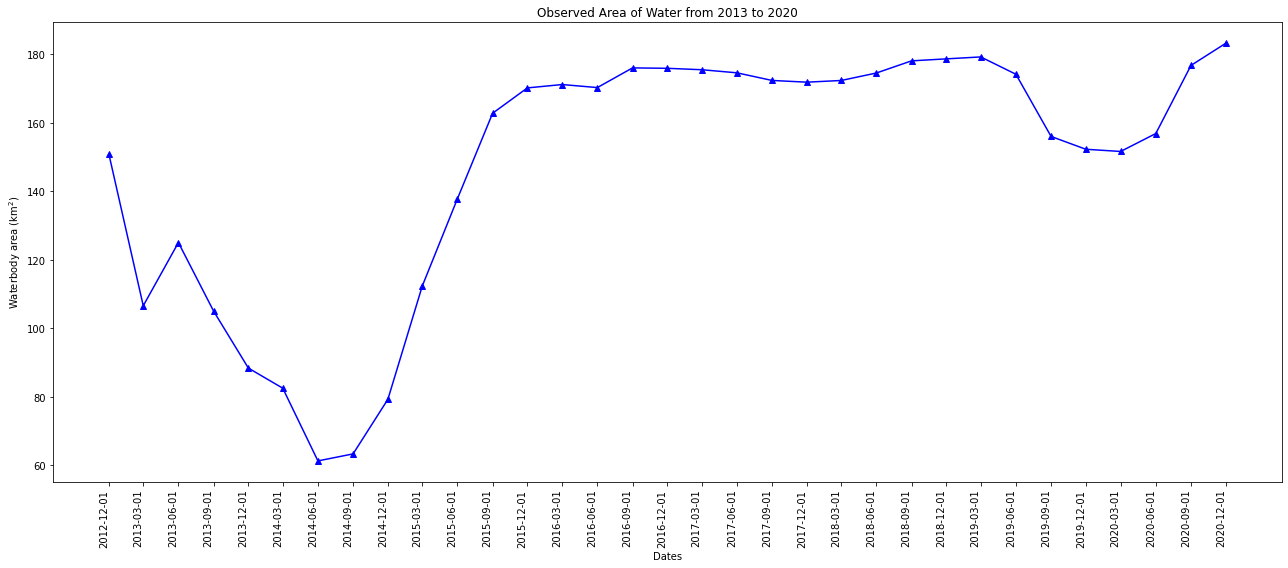

In [13]:
plt.figure(figsize=(18, 8))
ds_valid_water_area.water.plot(color='blue',marker='^')
plt.xticks(ds_valid_water_area.time.values,rotation = 90)
plt.title(f'Observed Area of Water from {time_range[0]} to {time_range[1]}')
plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)')
plt.tight_layout()

### Loading of CHIRPS Dataset

In [14]:
rf_ds = dc.load(product='rainfall_chirps_monthly',  **water_query)

In [15]:
rf_ds

<xarray.Dataset>
Dimensions:      (time: 96, x: 377, y: 846)
Coordinates:
  * time         (time) datetime64[ns] 2013-01-16T11:59:59.500000 ... 2020-12...
  * y            (y) float64 9.302e+04 9.298e+04 ... 6.77e+04 6.766e+04
  * x            (x) float64 3.475e+06 3.475e+06 ... 3.487e+06 3.487e+06
    spatial_ref  int32 6933
Data variables:
    rainfall     (time, y, x) float32 27.375816 27.375816 ... 10.040013
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [16]:
var = 'rainfall'
rf_plot = rf_ds[var].mean(['y','x'])

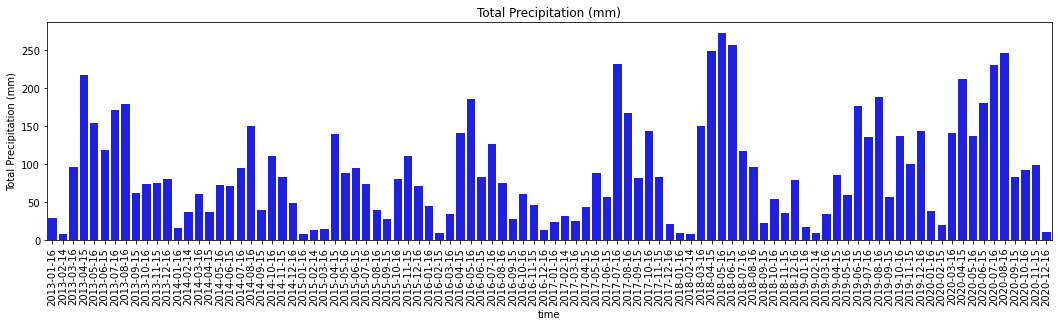

In [17]:
date_con = (pd.to_datetime(rf_plot.time.values)).date
plt.figure(figsize=(18, 4))
ax = sns.barplot(x= date_con, y=rf_plot.values, color='blue')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.ylabel('%s (%s)'%('Total Precipitation', rf_ds[var].attrs['units']));
plt.title('%s (%s)'%('Total Precipitation', rf_ds[var].attrs['units']))
plt.xlabel('time')
plt.show()

#### Combine the Plot

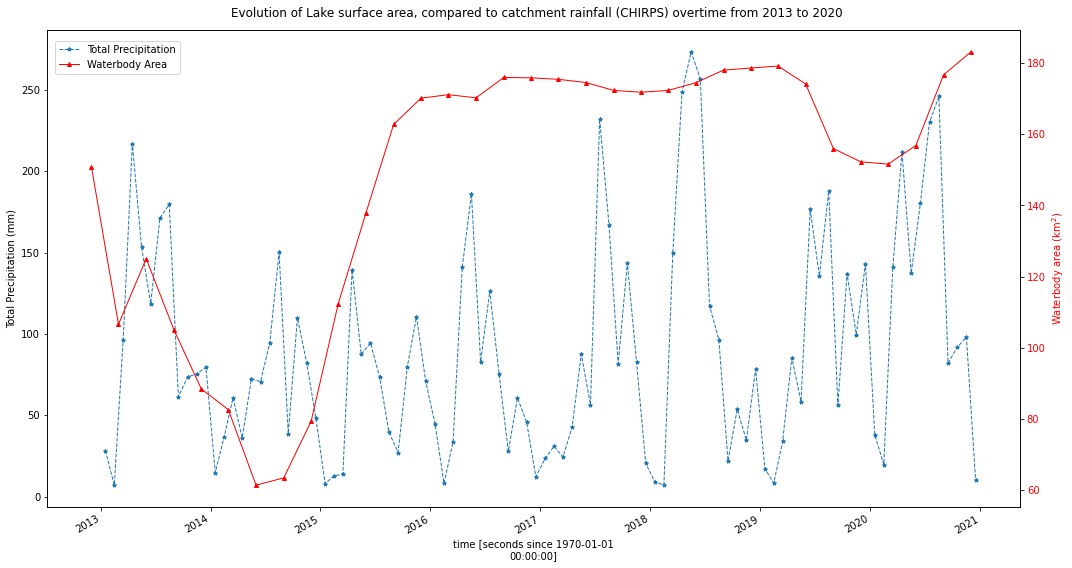

In [18]:
# plot daily total precipitation for this area

fig, ax1 = plt.subplots(figsize=(15,8))

# plt.subplot(2,1,1)
rf_plot.plot(marker='*', markersize=4, linewidth=1, ax=ax1, linestyle='dashed', 
                                    label='Total Precipitation');
# plt.xlabel('');
plt.ylabel('%s (%s)'%('Total Precipitation', rf_ds[var].attrs['units']));
plt.title('')

ax2 = ax1.twinx()
# plt.subplot(2,1,2)
ds_valid_water_area.water.plot(color='red', marker='^', 
                               markersize=4, linewidth=1, ax=ax2, label='Waterbody Area')
plt.title('')
# plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)', color='red')
plt.yticks(color='red')

fig.legend(loc='upper left', bbox_to_anchor=(0.05, 0.93))
fig.suptitle('Evolution of Lake surface area, compared to catchment rainfall (CHIRPS) over'+ 
             f'time from {time_range[0]} to {time_range[1]}')
fig.tight_layout()
fig.show()

#### Seasonal Rainfall (MAM- March-April-May; OND - October-November-December; LTM- Long Term Mean)

In [19]:
prep_mam = rf_ds.where(rf_ds['time.month'].isin([3, 4, 5]), 0)
prep_ons = rf_ds.where(rf_ds['time.month'].isin([10, 11, 12]), 0)

prep_mam = prep_mam.groupby('time.year').sum()
prep_ons = prep_ons.groupby('time.year').sum()

##### Calcualate Seasonal Mean 

In [20]:
mam_mean = prep_mam[var].mean()
ons_mean = prep_ons[var].mean()

##### Plot Seasonal Mean with Seasonal Rainfall

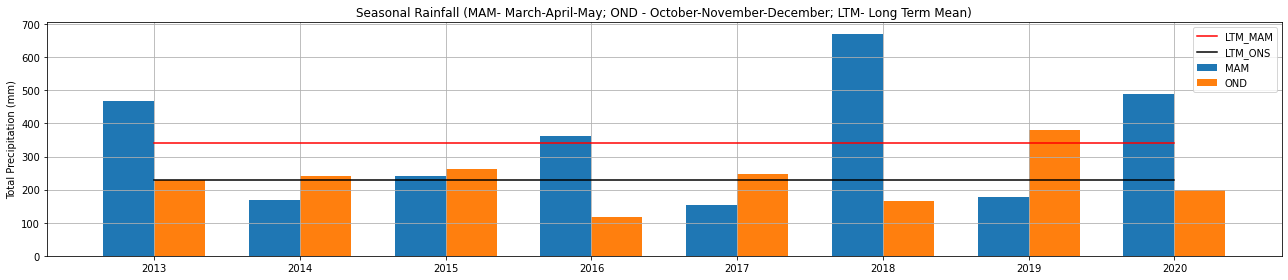

In [21]:
fig, ax = plt.subplots(figsize=(18, 4))
x = np.arange(len(prep_ons.year.values))
width=0.35

rects1 = ax.bar(x - width/2, prep_mam[var].mean(['y','x']).values, width, label='MAM')
rects2 = ax.bar(x + width/2, prep_ons[var].mean(['y','x']).values, width, label='OND')
rects3 = ax.plot(x, np.repeat(mam_mean.values, len(prep_ons.year.values)), color='red', label='LTM_MAM')
rects4 = ax.plot(x, np.repeat(ons_mean.values, len(prep_ons.year.values)), color='black', label='LTM_ONS')

ax.set_ylabel('%s (%s)'%('Total Precipitation', rf_ds[var].attrs['units']))
ax.set_title('Seasonal Rainfall (MAM- March-April-May; OND - October-November-December; LTM- Long Term Mean)')
ax.set_xticks(x)
ax.set_xticklabels(prep_ons.year.values)
ax.legend()
ax.grid()

fig.tight_layout()

plt.show()

## Determine minimum and maximum water extent

The next cell extracts the date of the minimum and maximum extent of water from the dataset using the `min` and `max` functions, we then add the dates to an `xarray.DataArray`.

## Compare water extent between two periods

* `baseline_time` : The baseline year for the analysis
* `analysis_time` : The year to compare to the baseline year

* The water extent for the two time-periods are extracted from the datatset `ds_valid_water_area`

In [22]:
baseline_time = '2013-06-01'
analysis_time = '2020-06-01'

baseline_ds, analysis_ds = ds_valid_water_area.sel(time=baseline_time, method ='nearest'),ds_valid_water_area.sel(time=analysis_time, method ='nearest')

In [23]:
time_xr = xr.DataArray([baseline_ds.time.values, analysis_ds.time.values], dims=["time"])

## Plotting
Plot water extent of the WOfS product for the two chosen periods.

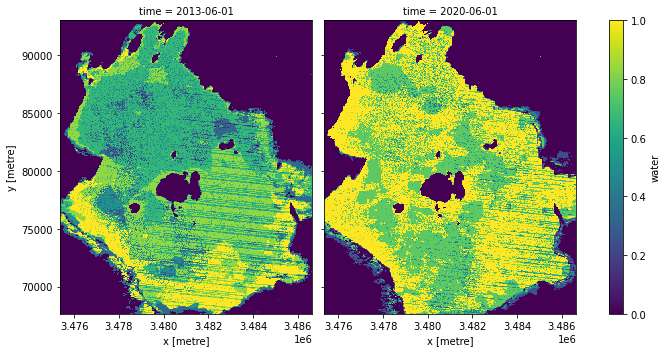

In [24]:
area_ds = wofls.water
area_ds.sel(time=time_xr).plot(col="time", col_wrap=2, robust=True, figsize=(10, 5), cmap='viridis');

### Calculate the change between the two nominated periods

The cells below calculate the amount of water gain, loss and stable for the two periods

In [25]:
ds_selected = area_ds.where(area_ds < 0.5, 1).sel(time=time_xr)

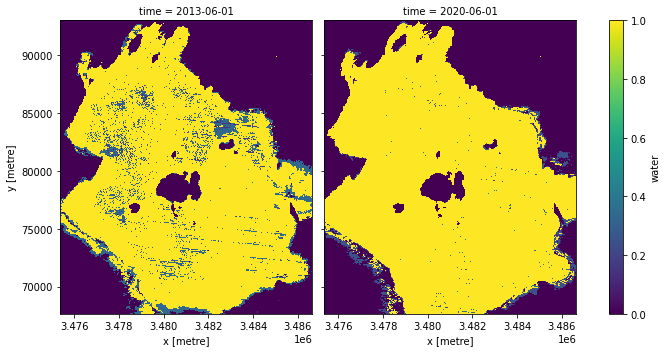

In [26]:
ds_selected.sel(time=time_xr).plot(col="time", col_wrap=2, robust=True, figsize=(10, 5), cmap='viridis');

In [28]:
#The dataset array is transform to 1 and 0 using the `astype(int)` function.
analyse_total_value = ds_selected[1]
change = analyse_total_value - ds_selected[0]

#The various scenarios are extracted from the `change` variable for the two years
#Water gain > 0
water_appeared = change.where(change > 0)

#Permanent water = 0
permanent_water = change.where((change == 0) & (analyse_total_value == 1))
# permanent_water = change.where(change == 0)

#Permanent Land = 0
permanent_land = change.where((change == 0) & (analyse_total_value == 0))

#Water loss < -1
water_disappeared = change.where(change < 0)

The cell below calculate the area of water extent for water_loss, water_gain, permanent water and land 

In [29]:
total_area = analyse_total_value.count().values * area_per_pixel
water_apperaed_area = water_appeared.count().values * area_per_pixel
permanent_water_area = permanent_water.count().values * area_per_pixel
permanent_land_area = permanent_land.count().values * area_per_pixel
water_disappeared_area = water_disappeared.count().values * area_per_pixel

The cell below calculate the percentage of area of water extent for water_loss, water_gain, permanent water and land 

In [30]:
# Percentage Change in water extent
percentage_water_gain = round((water_apperaed_area /  total_area) * 100 , 2)
percentage_water_loss = round(water_disappeared_area /  total_area * 100 , 2)
percentage_permanent_water = round(permanent_water_area /  total_area * 100 , 2)
percentage_permanent_land = round(permanent_land_area /  total_area * 100, 2)

## Plot the changes
The water variables are plotted to visualised the result

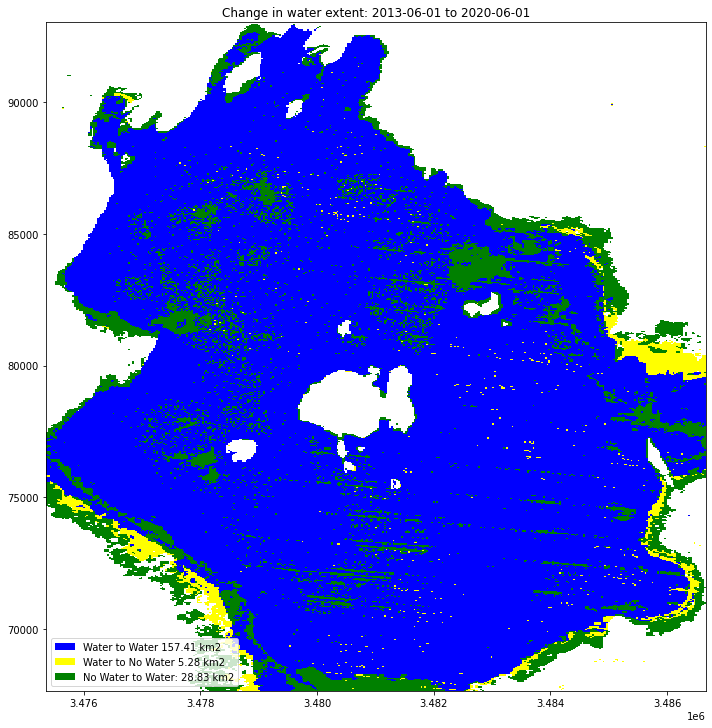

In [31]:
water_appeared_color = "Green"
water_disappeared_color = "Yellow"
stable_color = "Blue"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

water_appeared.plot.imshow(
    cmap=ListedColormap([water_appeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
water_disappeared.plot.imshow(
    cmap=ListedColormap([water_disappeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
permanent_water.plot.imshow(cmap=ListedColormap([stable_color]),
                            add_colorbar=False,
                            add_labels=False,
                            ax=ax)

plt.legend(
    [
        Patch(facecolor=stable_color),
        Patch(facecolor=water_disappeared_color),
        Patch(facecolor=water_appeared_color),
    ],
    [
        f"Water to Water {round(permanent_water_area, 2)} km2",
        f"Water to No Water {round(water_disappeared_area, 2)} km2",
        f"No Water to Water: {round(water_apperaed_area, 2)} km2",
    ],
    loc="lower left",
)

plt.tight_layout()
plt.title('Change in water extent: '+baseline_time+' to '+analysis_time);


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [32]:
print(datacube.__version__)

1.8.5


**Last Tested:**

In [33]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-09-20'